## 0. Getting setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")

torch version: 2.2.2
torchvision version: 0.17.2


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
except:
    print("[INFO] Couldn't find going_modular script")
try:
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print(f"[INFO] Couldn't find helper_functions")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get Data

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manualy created transforms: {manual_transforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff5420c0310>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch =  next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

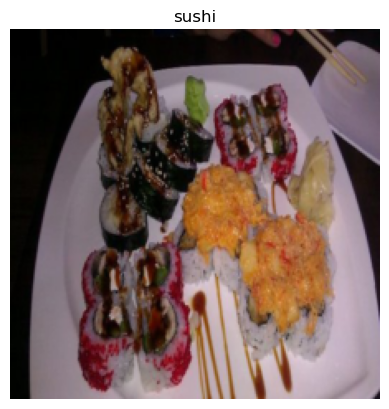

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
print(f"NUmber of patches (N) with image height (H={height}), width (W={width}) and patch_size (P={patch_size})")

NUmber of patches (N) with image height (H=224), width (W=224) and patch_size (P=16)


* Input: The image starts as 2D with H x W x C
* Output: The image gets converted to a sequence of fllatened 2D patches with size N x (P^2 * C)

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (singel 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (singel 2D image flattened into patches): (196, 768)


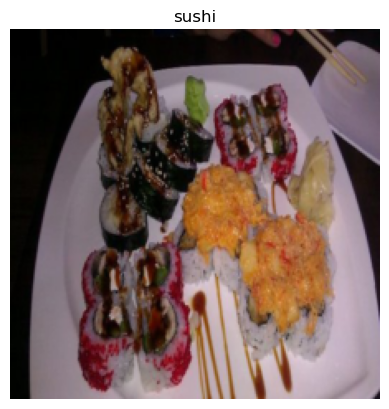

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

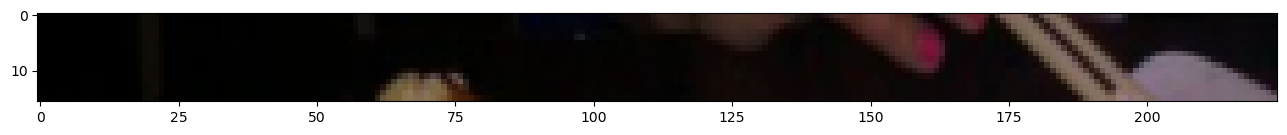

In [13]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


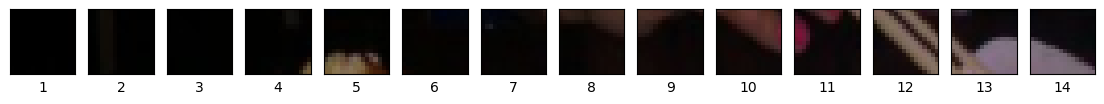

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


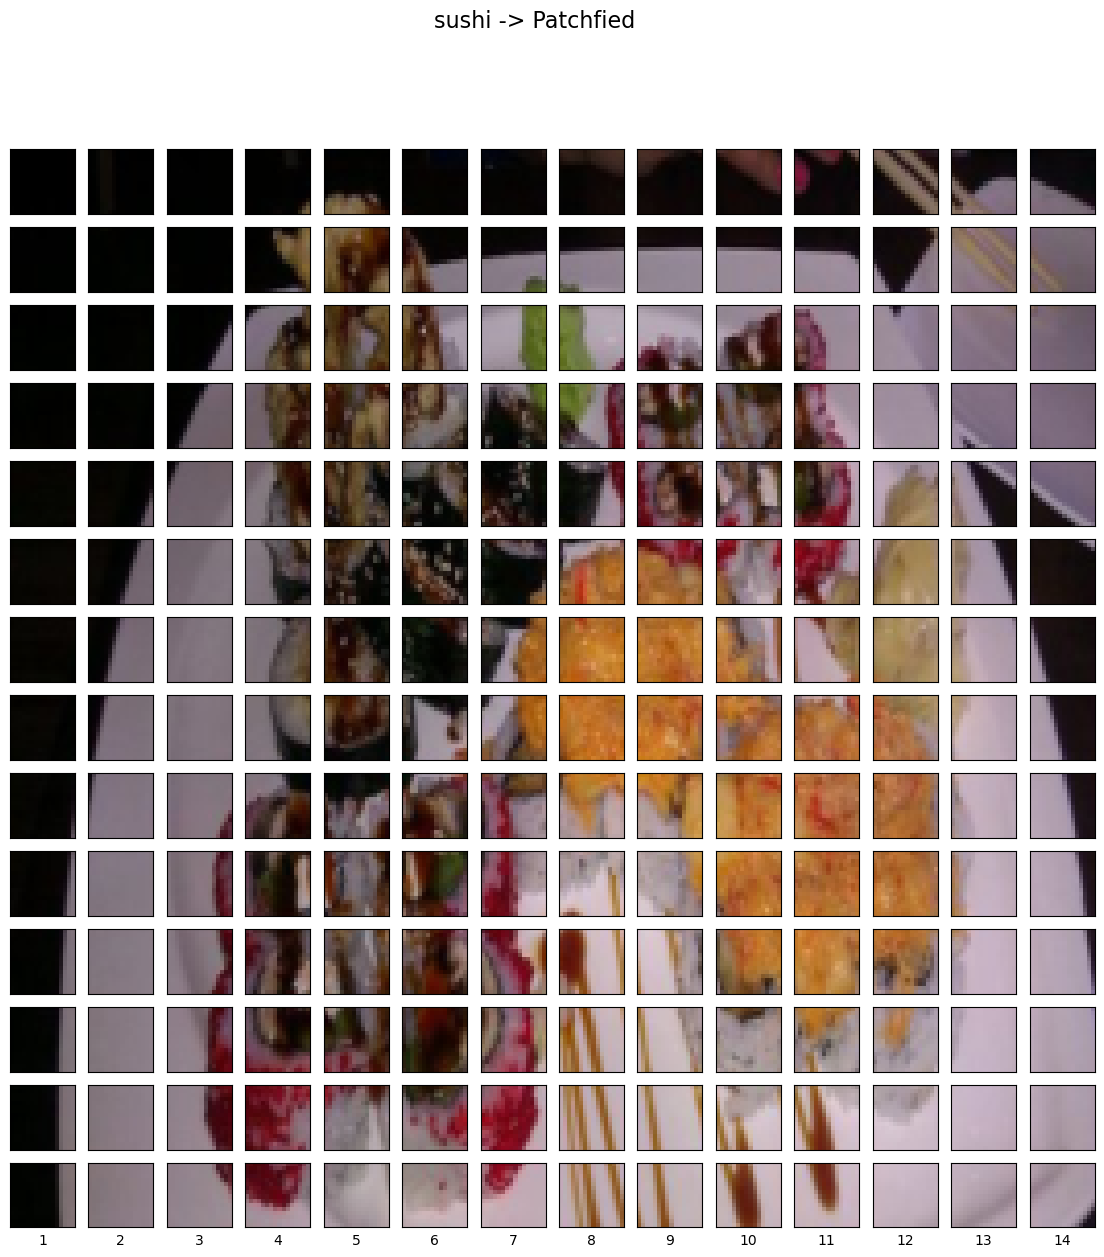

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image patch (image_permuted -> (H, W, C)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                         patch_width:patch_width+patch_size:])
        # Set up information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchfied", fontsize=16)
plt.show()

In [16]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

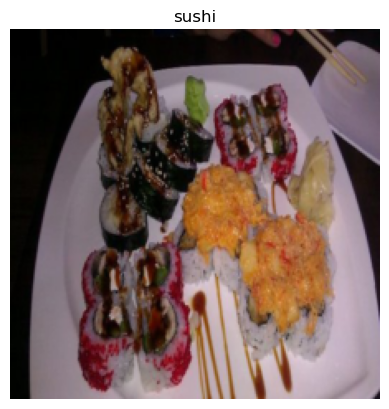

In [17]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))  # add a singel batch dim
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [717, 583, 676, 464, 158]


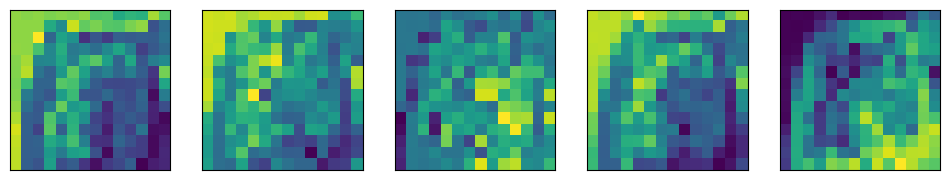

In [19]:
# PLot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0360,  0.0335,  0.0370,  0.0257,  0.1229,  0.0379,  0.0291,
           -0.0185,  0.0410, -0.0425,  0.0344,  0.0254,  0.3272,  0.1572],
          [ 0.0377,  0.0425,  0.0410,  0.0064,  0.1246,  0.3368,  0.2727,
            0.2225,  0.2421,  0.2706,  0.3348,  0.1696,  0.0436,  0.0415],
          [ 0.0422,  0.0445,  0.0828, -0.0883,  0.0887,  0.1496,  0.0510,
            0.1708, -0.1792, -0.0799,  0.0081,  0.0650,  0.0126,  0.0190],
          [ 0.0402,  0.0436,  0.0469,  0.0206,  0.1781,  0.1397,  0.0436,
            0.1403, -0.0172,  0.0592,  0.0298,  0.0532,  0.0012,  0.0139],
          [ 0.0443,  0.0386,  0.0069,  0.0720,  0.1099, -0.0105,  0.0910,
            0.2736, -0.0836,  0.2023, -0.0816,  0.0370, -0.1065, -0.0143],
          [ 0.0455,  0.0930,  0.0393, -0.0369, -0.0180,  0.0997,  0.0007,
            0.1144,  0.3130,  0.2636,  0.1483,  0.1810,  0.3322,  0.0240],
          [ 0.0394,  0.0920,  0.0341,  0.0470,  0.1762, -0.0127,  0.0930,
            0.2862,  0.2233,  0.

In [22]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [26]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


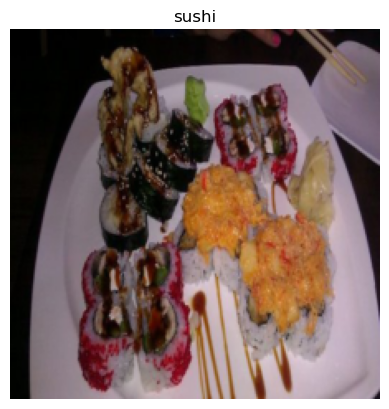

In [29]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dim to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatetn the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flatten image feature map shape: {image_out_of_conv_flattened.shape}")

In [30]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


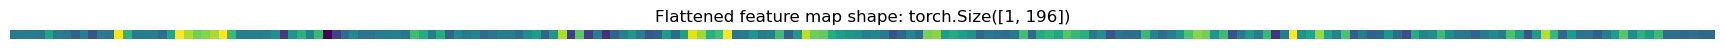

In [32]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [33]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0360,  0.0335,  0.0370,  0.0257,  0.1229,  0.0379,  0.0291, -0.0185,
           0.0410, -0.0425,  0.0344,  0.0254,  0.3272,  0.1572,  0.0377,  0.0425,
           0.0410,  0.0064,  0.1246,  0.3368,  0.2727,  0.2225,  0.2421,  0.2706,
           0.3348,  0.1696,  0.0436,  0.0415,  0.0422,  0.0445,  0.0828, -0.0883,
           0.0887,  0.1496,  0.0510,  0.1708, -0.1792, -0.0799,  0.0081,  0.0650,
           0.0126,  0.0190,  0.0402,  0.0436,  0.0469,  0.0206,  0.1781,  0.1397,
           0.0436,  0.1403, -0.0172,  0.0592,  0.0298,  0.0532,  0.0012,  0.0139,
           0.0443,  0.0386,  0.0069,  0.0720,  0.1099, -0.0105,  0.0910,  0.2736,
          -0.0836,  0.2023, -0.0816,  0.0370, -0.1065, -0.0143,  0.0455,  0.0930,
           0.0393, -0.0369, -0.0180,  0.0997,  0.0007,  0.1144,  0.3130,  0.2636,
           0.1483,  0.1810,  0.3322,  0.0240,  0.0394,  0.0920,  0.0341,  0.0470,
           0.1762, -0.0127,  0.0930,  0.2862,  0.2233,  0.2129,  0.1410,  0.1077,
           0.093

In [35]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input iamge into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defeault to 3
        patch_size (int): Size of patches to convert input image into. Default to 16.
        embedding_dim (int): Size of embedding to turn image into. Default to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # Create a layer  to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image shape: {image_resolution}.\
        patch_size: {patch_size}"

        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)
        return x_flatten.permute(0, 2, 1)  # [batch_size, N, P^2*C]

In [39]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                           patch_size=16,
                           embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [42]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)  # will error  because image size is incompatible with patch_size

summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17